# SAE2 : Communes bretonnes

In [1]:
# importation des packages
import numpy as np
import pandas as pd
import seaborn as sns
import ast as ast
from geopy.distance import geodesic
# importation des modules
import scipy.stats as sps


import networkx as nx


import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (20,15)

/home/user/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Le but de ce fichier est construire un graphe networkx à partir de données géolocalisée csv

### 1 Traitement des données csv :

In [2]:
# importation du fichier csv comme un panda dataframe
communes=pd.read_csv("./DonneesFourniesGraphes/voisinageCommunesBretonnes.csv", sep=';')

#on affiche les premières lignes du fichier
communes.head()



insee                  nom  nb_voisins  \
0  22001             Allineuc           5   
1  22002                Andel           5   
2  22003             Aucaleuc           4   
3  22004               Bégard           7   
4  22005  Belle-Isle-en-Terre           5   

                               insee_voisins  
0              22203|22203|22384|22149|22009  
1              22093|22093|22044|22093|22093  
2                    22259|22364|22388|22048  
3  22041|22018|22310|22164|22135|22245|22254  
4              22135|22216|22129|22228|22359

In [3]:
communes.columns


Index(['insee', 'nom', 'nb_voisins', 'insee_voisins'], dtype='object')

In [4]:
# adaptation du format des données en liste des voisins (exemple)
print(communes['insee_voisins'][0])

print(communes.iloc[0,3])

[int(num) for num in communes['insee_voisins'][0].split('|')]


22203|22203|22384|22149|22009
22203|22203|22384|22149|22009


[22203, 22203, 22384, 22149, 22009]

In [5]:
#on enlève les voisins non bretons (22+29+35+56) et les boucles

def amezek(com):
    voisins = [int(num) for num in communes['insee_voisins'][com].split('|')]
    amezek = []
    for vois in voisins :
        if (22000 <= vois and vois<23000) or (29000 <= vois and vois<30000) or (35000 <= vois and vois<36000) or (56000 <= vois and vois<57000) : #on reste en bretagne
            if vois != communes['insee'][com] : #boucle
                amezek.append(vois)
    return amezek


for x in range(len(communes['insee'])) : 
    amezek(x)

In [6]:
# Création d'un dictionaire représentant la liste des voisins, structure proche des graphes networkx

voisins_dict = {communes['insee'][x] : amezek(x) for x in range(len(communes['insee']))}
voisins_dict[29021]


[29064, 29198, 29091]

### 2 Création d'un graphe en format networkx

In [7]:
#creation directe via l'outil networkx
G = nx.from_dict_of_lists(voisins_dict)

print(len(G.nodes))
#for node in G.nodes:
#    print(node)
    

1197


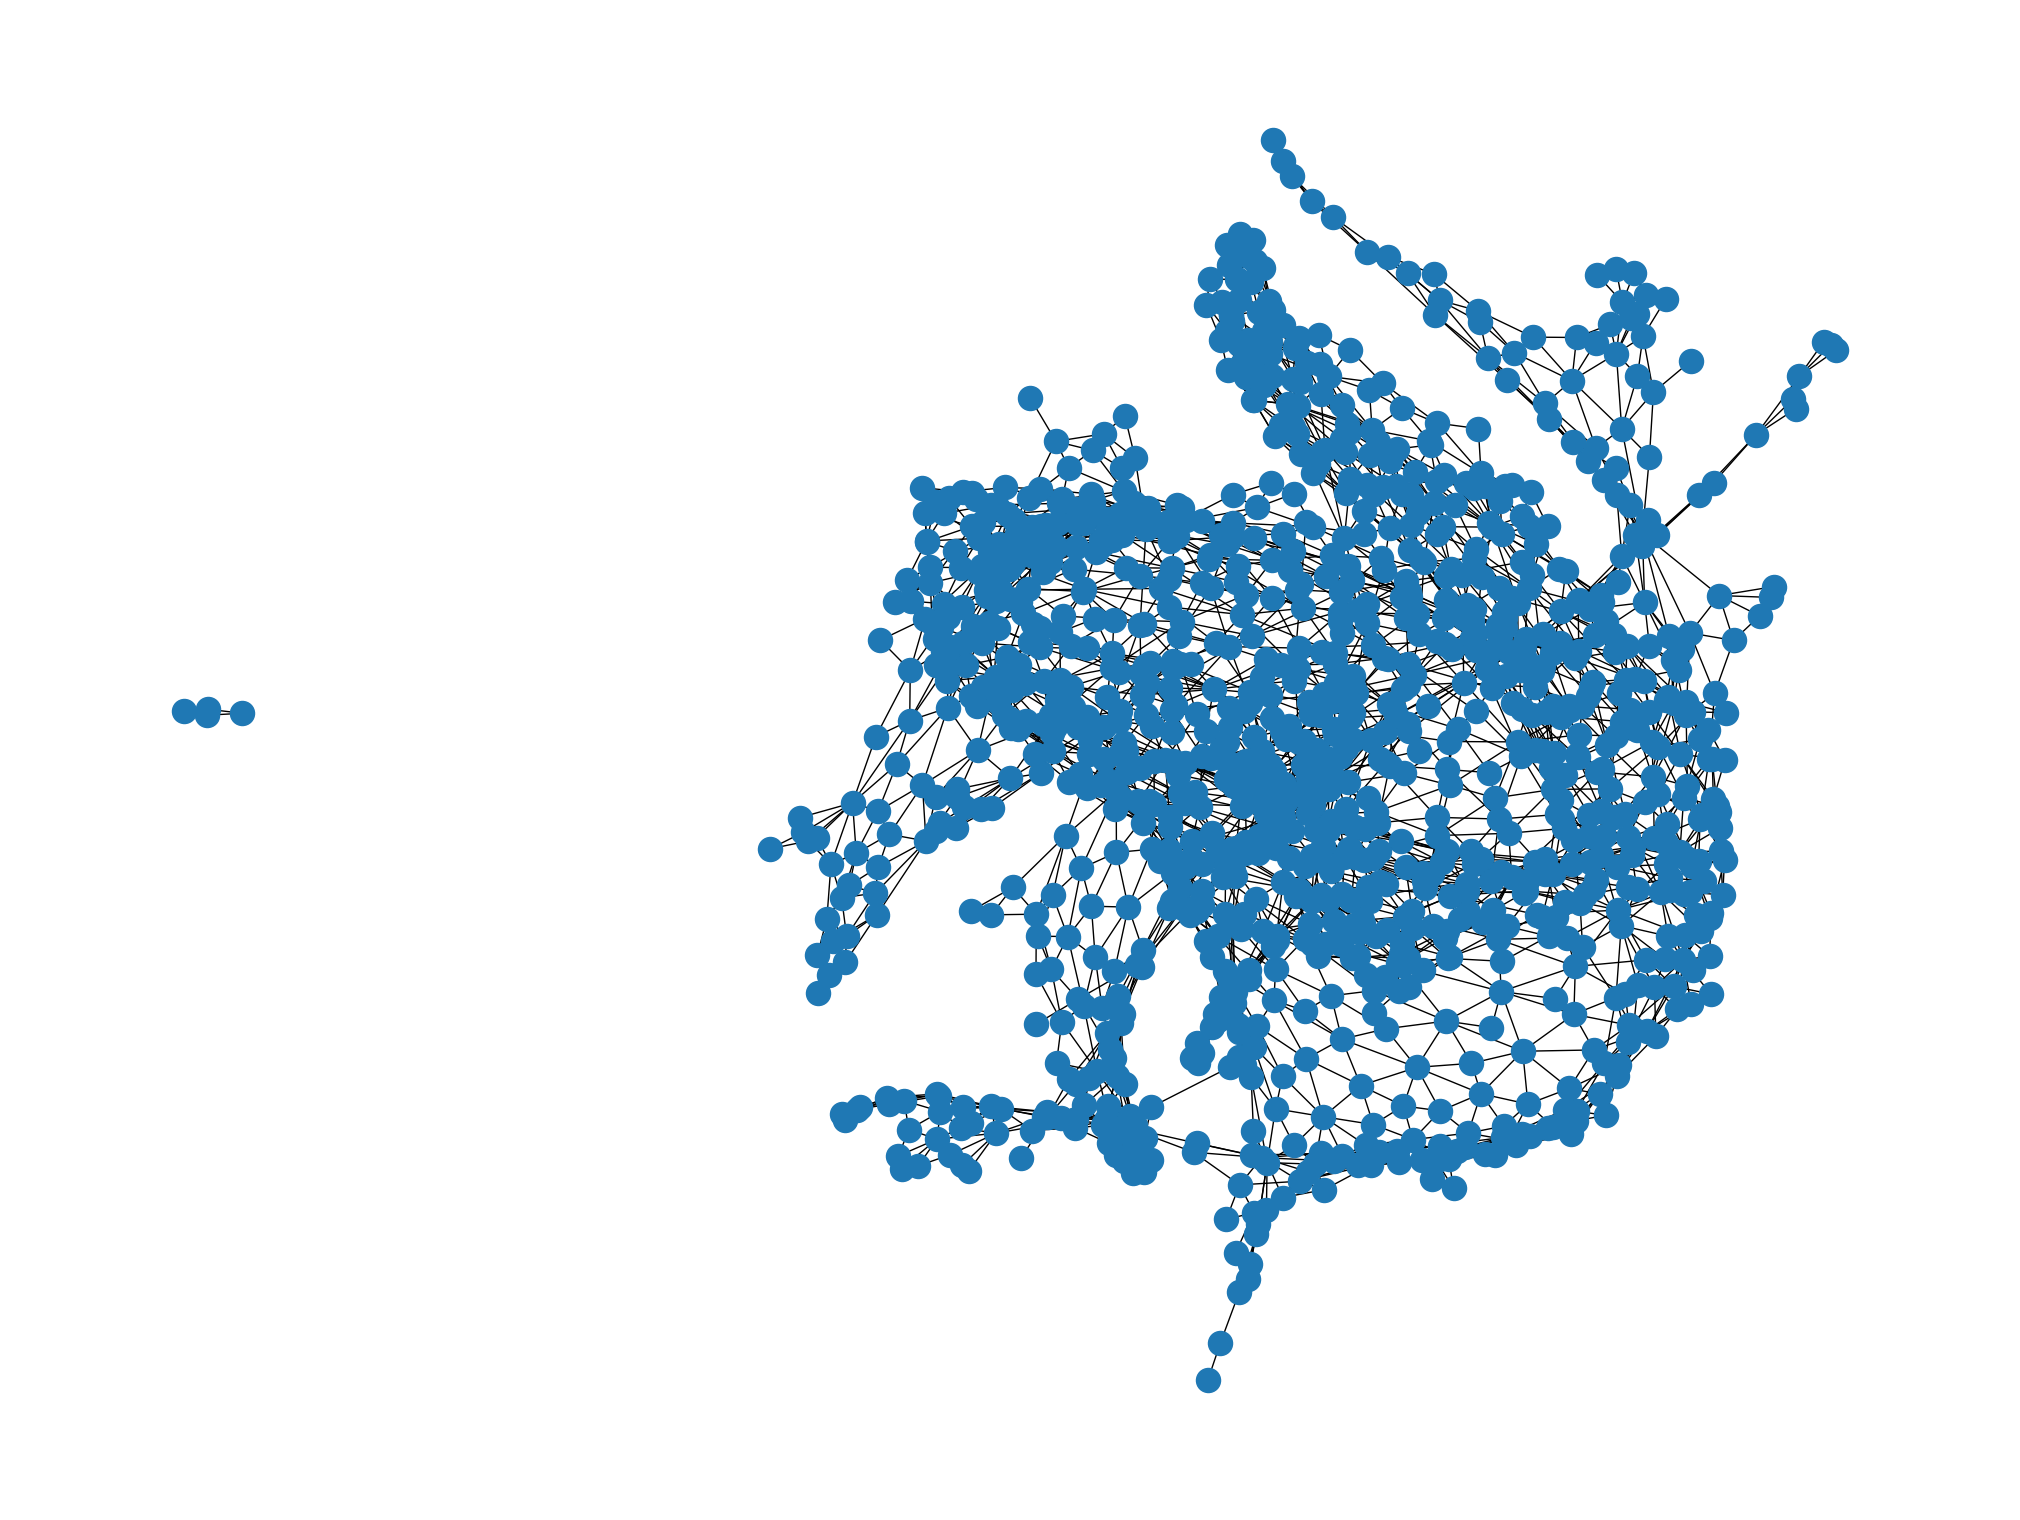

In [8]:
#pour l'instant les sommets ne sont pas placés géographiquement
nx.draw(G,pos=nx.spring_layout(G))


### 3 Exploitation des données géographiques

In [9]:
#lecture des informations geographique

geo=pd.read_csv("./DonneesFourniesGraphes/communes-geo.csv", sep=';')

geo.head()
geo_lite = geo.iloc[:,[0,1,17,19]]

geo_lite.columns

geo_lite['Geo Point'][0]

'47.965835834555435, -2.180339647082372'

In [10]:
# adaptation du format des données de géolocalisation (exemple)
ast.literal_eval(geo_lite['Geo Point'][0])

# création de la colone Latitude
geo_lite['Latitude']=geo_lite['Geo Point'].apply(lambda x : ast.literal_eval(x)[0])
# création de la colone Longitude
geo_lite['Longitude']=geo_lite['Geo Point'].apply(lambda x : ast.literal_eval(x)[1])

geo_lite.head()

Geo Point  \
0   47.965835834555435, -2.180339647082372   
1    48.13658848473797, -3.604143385699294   
2   47.66115932253269, -2.8979142904691706   
3     47.8257861710007, -2.623531946315434   
4  48.561815546029436, -2.3352456790830622   

                                           Geo Shape  Code Officiel Commune  \
0  {"coordinates": [[[-2.138393408174076, 47.9796...                  56012   
1  {"coordinates": [[[-3.598896445577899, 48.0809...                  56066   
2  {"coordinates": [[[-2.914167012351387, 47.6298...                  56167   
3  {"coordinates": [[[-2.559861319644625, 47.7984...                  56172   
4  {"coordinates": [[[-2.340377140698437, 48.5296...                  22268   

  Nom Officiel Commune   Latitude  Longitude  
0              Beignon  47.965836  -2.180340  
1               Gourin  48.136588  -3.604143  
2         Plougoumelen  47.661159  -2.897914  
3             Plumelec  47.825786  -2.623532  
4                 Ruca  48.561816  -2.335246

In [11]:
#ajout des données géographique



# proposition de dictionaire de position pour le tracé en networkx

def pos_insee(G,data):
    pos = {} #dictionnaire vide
    for com in G.nodes:
        y = float(data[data['Code Officiel Commune'] == com]['Latitude'].iloc[0])
        x = float(data[data['Code Officiel Commune'] == com]['Longitude'].iloc[0])
        #on peut adapter les coordonnées
        #x=(x- 48.13380133652042)*1000
        #y=(y+2.287539276431153)*1000
    
        pos[com]=[x,y]
    
    return pos

pos_insee = pos_insee(G,geo_lite)
#print(pos_insee)

print(len(G.nodes)==len(pos_insee))

print(pos_insee[56167])

True
[-2.8979142904691706, 47.66115932253269]


In [12]:
# proposition de dictionaire de label pour le tracé en networkx

def label_insee(G,data):
    label = {} #dictionnaire vide
    for com in G.nodes:
        lab = data[data['Code Officiel Commune'] == com]['Nom Officiel Commune'].iloc[0]
    
        label[com]=lab
    
    return label

label_insee = label_insee(G,geo_lite)
label_insee

{22001: 'Allineuc',
 22002: 'Andel',
 22003: 'Aucaleuc',
 22004: 'Bégard',
 22005: 'Belle-Isle-en-Terre',
 22006: 'Berhet',
 22055: 'Binic-Étables-sur-Mer',
 22008: 'Bobital',
 22009: 'Le Bodéo',
 22011: 'Boqueho',
 22012: 'La Bouillie',
 22013: 'Bourbriac',
 22014: 'Bourseul',
 22015: 'Bréhand',
 22018: 'Brélidy',
 22019: 'Bringolo',
 22020: 'Broons',
 22021: 'Brusvily',
 22023: 'Bulat-Pestivien',
 22024: 'Calanhel',
 22025: 'Callac',
 22026: 'Calorguen',
 22027: 'Le Cambout',
 22028: 'Camlez',
 22029: 'Canihuel',
 22030: 'Caouënnec-Lanvézéac',
 22031: 'Carnoët',
 22032: 'Caulnes',
 22033: 'Caurel',
 22034: 'Cavan',
 22035: 'Les Champs-Géraux',
 22036: 'La Chapelle-Blanche',
 22037: 'La Chapelle-Neuve',
 22206: 'Châtelaudren-Plouagat',
 22039: 'La Chèze',
 22040: 'Coadout',
 22041: 'Coatascorn',
 22042: 'Coatréven',
 22043: 'Coëtlogon',
 22044: 'Coëtmieux',
 22045: 'Cohiniac',
 22046: 'Le Mené',
 22047: 'Corlay',
 22048: 'Corseul',
 22049: 'Créhen',
 22050: 'Dinan',
 22084: 'Jugon-les

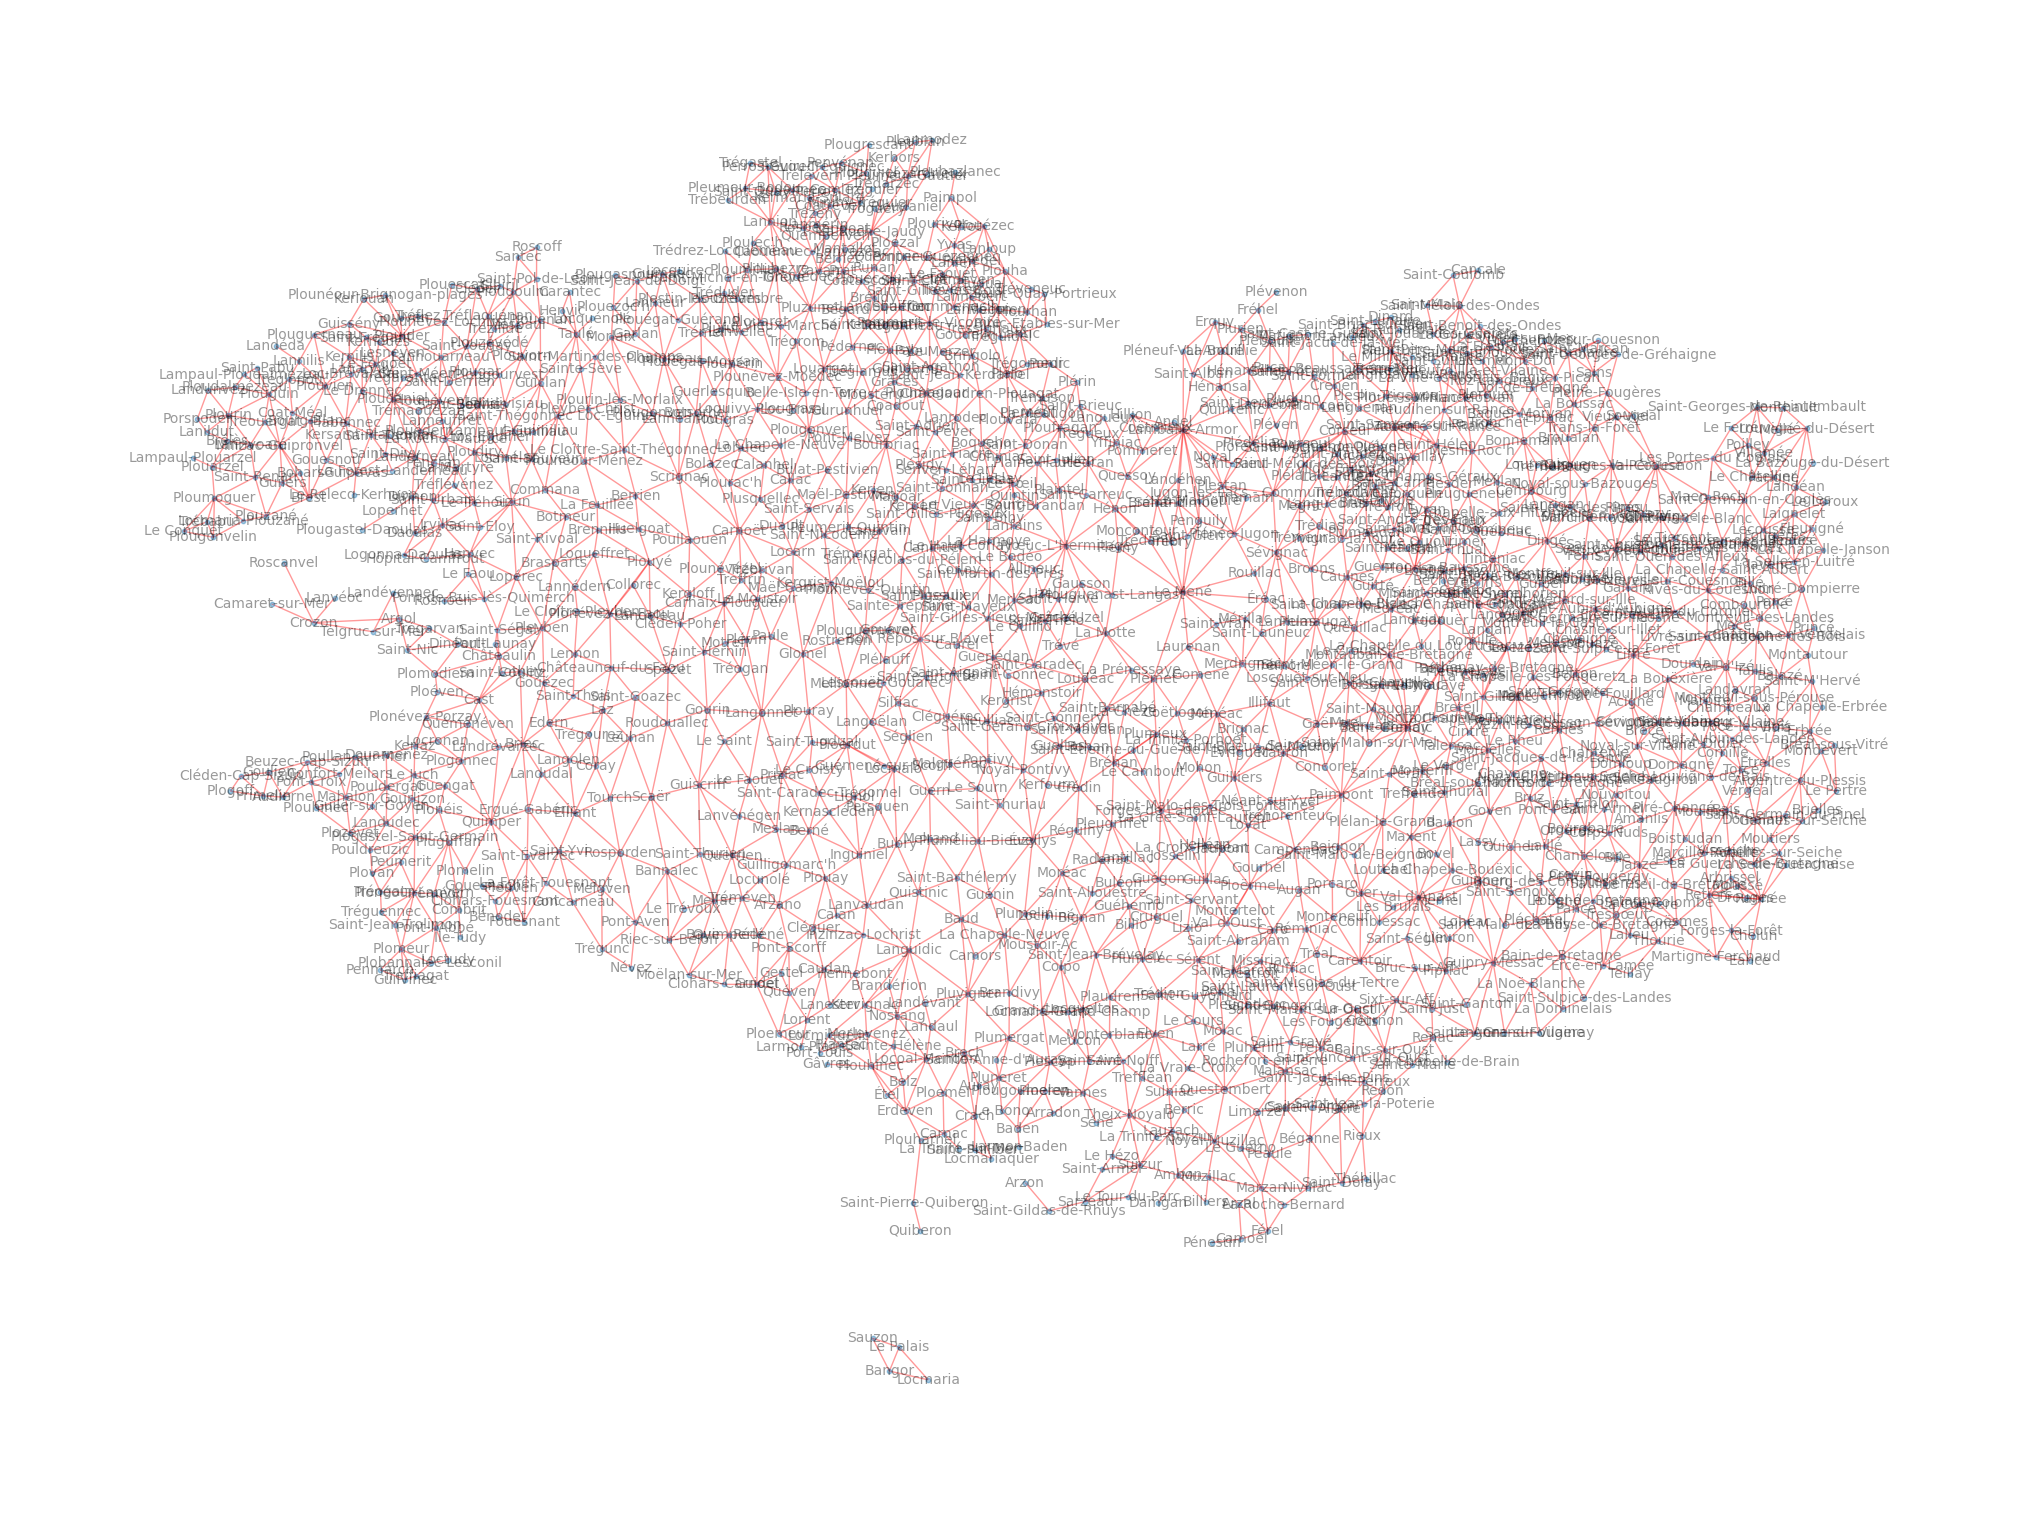

In [13]:
nx.draw(G,pos=pos_insee,node_size=10, alpha=0.4, edge_color="r", font_size=10, labels=label_insee)

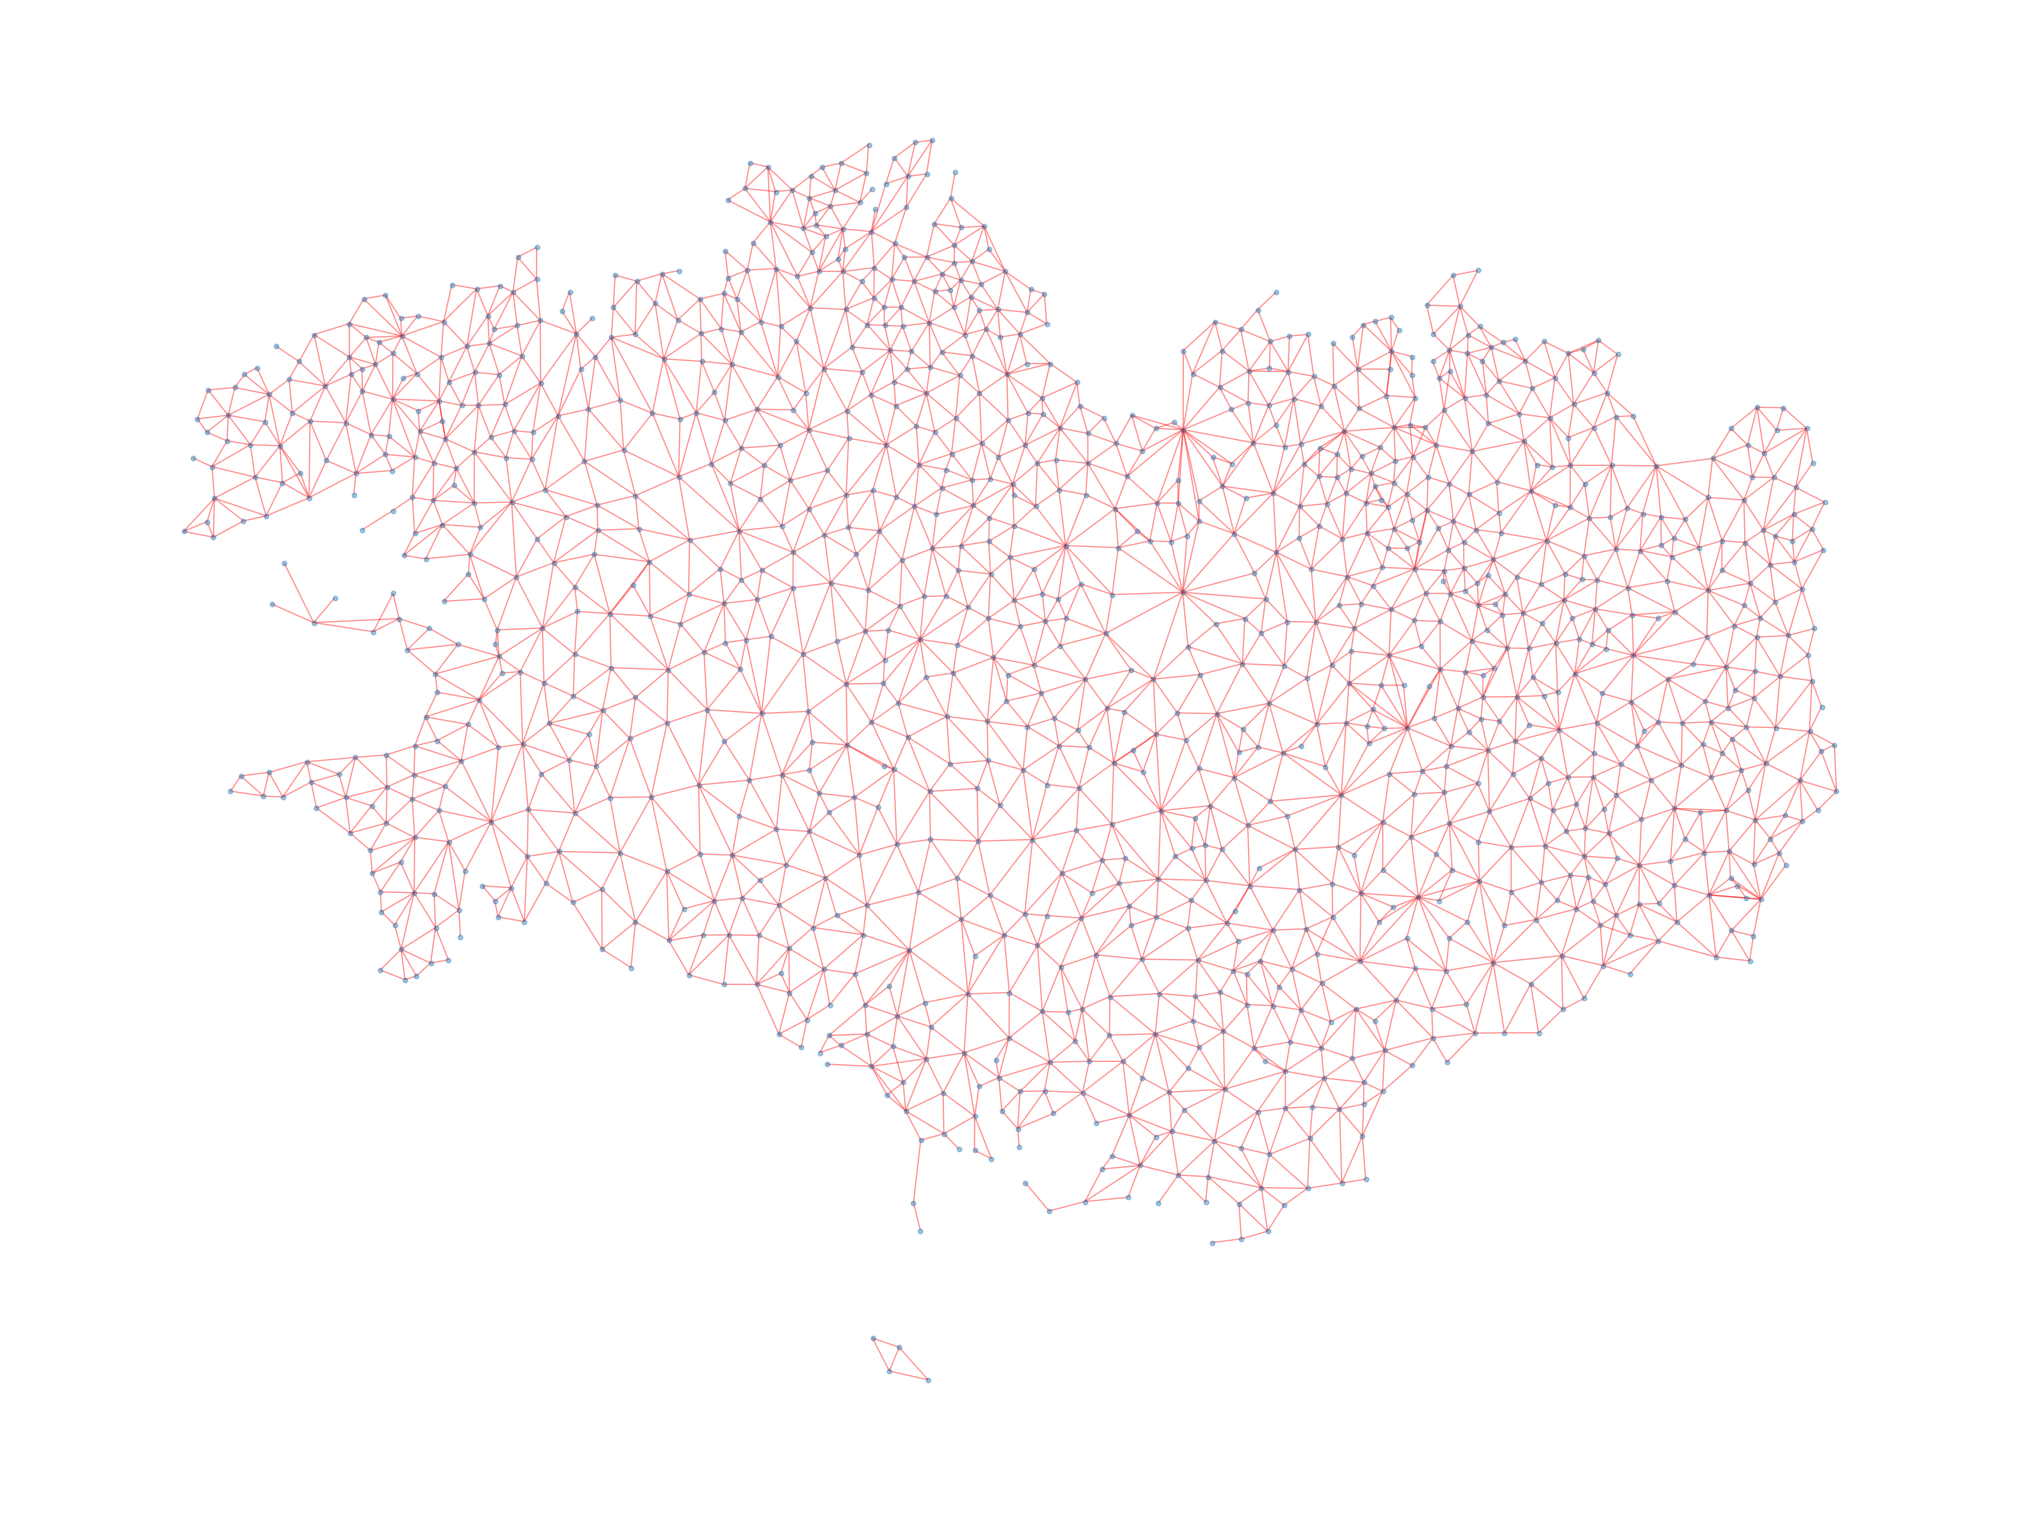

In [14]:
G.remove_edges_from(list(nx.selfloop_edges(G)))
nx.draw(G,pos=pos_insee,node_size=10, alpha=0.4, edge_color="r", font_size=16, with_labels=False)

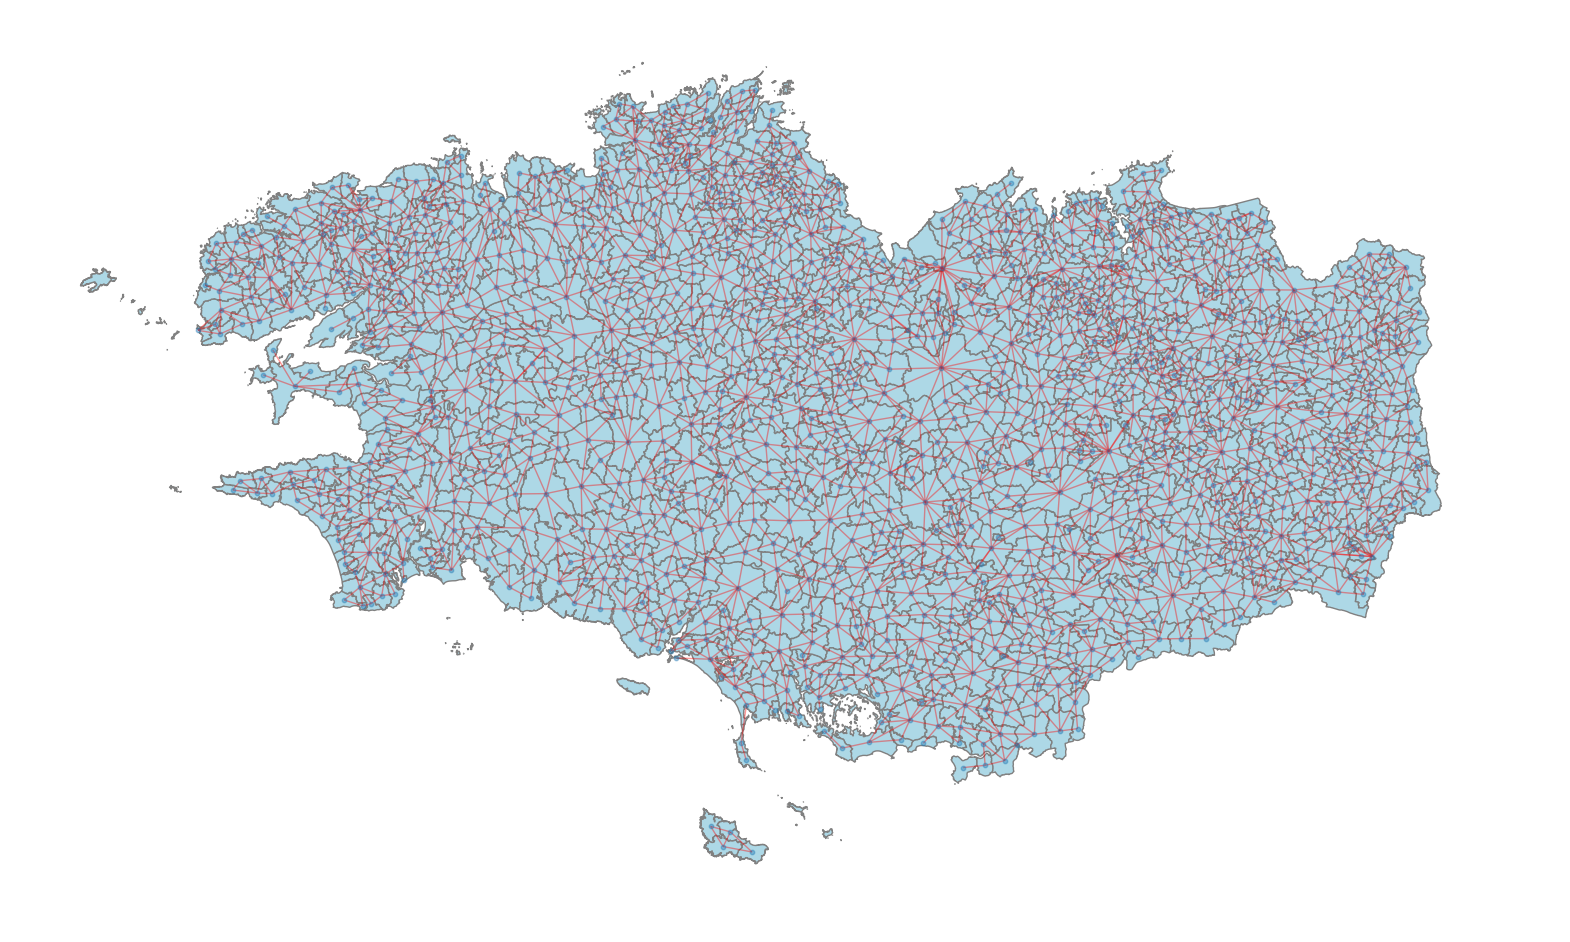

In [15]:
#on peut également utiliser des fonds de carte (via le format geojson par exemple)

import geopandas
region = geopandas.read_file("./DonneesFourniesGraphes/communes-geo.geojson")


plt.close()
# plot with a nice basemap
ax = region.plot(linewidth=1, edgecolor="grey", facecolor="lightblue")
ax.axis("off")
nx.draw(G, pos=pos_insee, ax=ax,node_size=10, alpha=0.4, edge_color="r")
plt.show()

In [16]:
def calculate_eccentricity(G):
    eccentricities = {}
    for sommet in G.nodes():
        try:
            # Calcule de la longueur du chemin le plus court entre le sommet actuel et tous les autres via dijkstra
            distances = nx.single_source_dijkstra_path_length(G, sommet)
            
            # L'excentricité d'un sommet est la distance max qui le sépare de tout autre sommet
            eccentricities[sommet] = max(distances.values())
        except nx.NetworkXNoPath:
            # S'il n'y a pas de chemin entre le sommet et un autre sommet
            eccentricities[sommet] = None
    return eccentricities



eccentricities = calculate_eccentricity(G)

for sommet, ecc in eccentricities.items():
    if ecc is not None: # On s'assure que ce n'est pas None (aucun chemin entre le sommet et un autre sommet)
        print("Excentricité de "+str(sommet)+" : "+str(ecc))


Excentricité de 22001 : 25
Excentricité de 22002 : 29
Excentricité de 22003 : 32
Excentricité de 22004 : 29
Excentricité de 22005 : 29
Excentricité de 22006 : 31
Excentricité de 22055 : 27
Excentricité de 22008 : 33
Excentricité de 22009 : 24
Excentricité de 22011 : 24
Excentricité de 22012 : 30
Excentricité de 22013 : 26
Excentricité de 22014 : 30
Excentricité de 22015 : 27
Excentricité de 22018 : 30
Excentricité de 22019 : 25
Excentricité de 22020 : 30
Excentricité de 22021 : 32
Excentricité de 22023 : 28
Excentricité de 22024 : 30
Excentricité de 22025 : 29
Excentricité de 22026 : 34
Excentricité de 22027 : 27
Excentricité de 22028 : 33
Excentricité de 22029 : 24
Excentricité de 22030 : 31
Excentricité de 22031 : 29
Excentricité de 22032 : 31
Excentricité de 22033 : 23
Excentricité de 22034 : 30
Excentricité de 22035 : 34
Excentricité de 22036 : 32
Excentricité de 22037 : 29
Excentricité de 22206 : 25
Excentricité de 22039 : 27
Excentricité de 22040 : 27
Excentricité de 22041 : 30
E

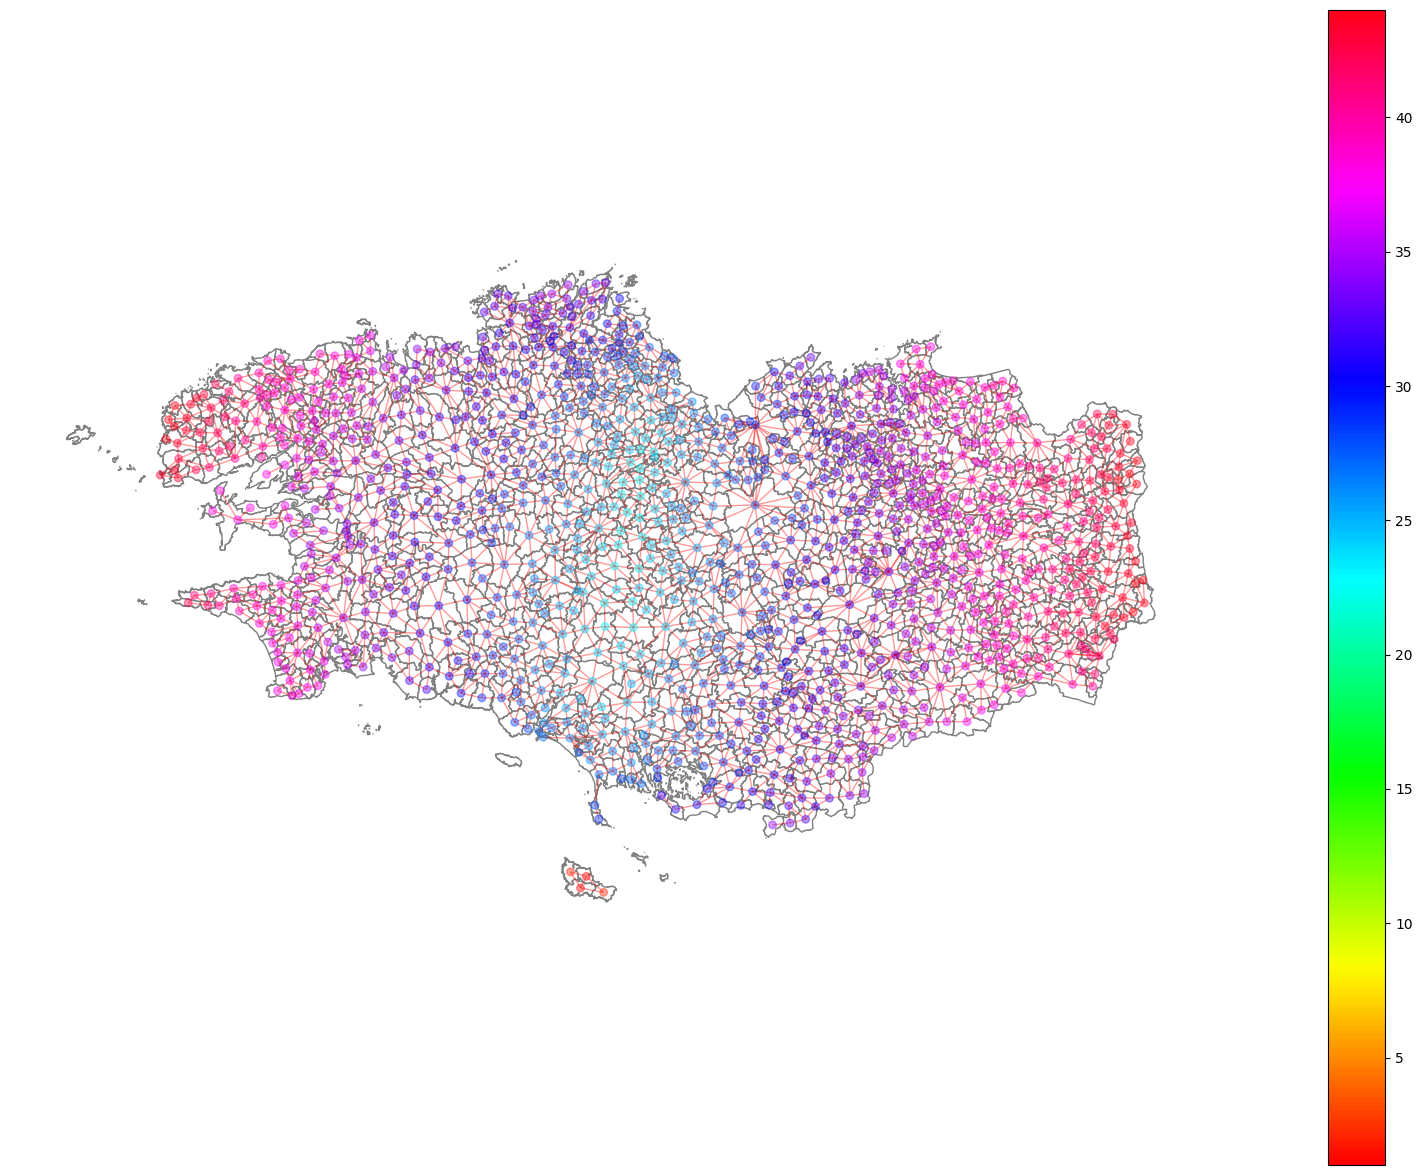

In [31]:

# Plot de l'exentricité
plt.close()
# plot with a nice basemap
ax = region.plot(linewidth=1, edgecolor="grey", facecolor="white")
ax.axis("off")
cmap = plt.get_cmap('hsv')  # Choix de la colormap
nx.draw(G, cmap=cmap, pos=pos_insee, ax=ax,node_size=30, alpha=0.4, edge_color="r", node_color=tuple(eccentricities.values()))

norm = plt.Normalize(min(eccentricities.values()), max(eccentricities.values()))

# Add a colorbar
plt.colorbar(img, ax=ax, orientation="vertical")

plt.show()

plt.close()